In [1]:
!pip install transformers sentencepiece datasets

In [2]:
import transformers
import sentencepiece
import datasets
import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import itertools

from datasets import load_dataset
from transformers import AdamW, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import get_linear_schedule_with_warmup

In [3]:
# maybe want to use  mt5-base
model_repo = 'google/mt5-small'

Loading the pretrained tokenizer and model

In [4]:
# download mt5 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_repo)
# download model
model= AutoModelForSeq2SeqLM.from_pretrained(model_repo)
# puts model onto GPU
model = model.cuda()

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

testing the tokenizer

In [5]:
# initalize test sentence
input = 'this is a sentence'
# tokenize sentence, convert to tensor, and put onto GPU
token_ids = tokenizer.encode(input, return_tensors='pt').cuda()
# show tokenized sentence
print(token_ids)

tensor([[  714,   339,   259,   262,   259, 98923,     1]], device='cuda:0')


In [6]:
# put input through model
output = model.generate(token_ids)
# convert output to tokens and then to string
output_str = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(output[0])
    )
print(output_str)

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<pad> <extra_id_0></s>


In [7]:
example_input = '<sp> this nis a sentence fsdff'
input_ids = tokenizer.encode(example_input, return_tensors='pt').cuda()
print(input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)

tensor([[ 1042,   263,   325,   669,   714,   568,   263,   259,   262,   259,
         98923,   742,   263,   285,  2547,     1]], device='cuda:0')
['▁<', 's', 'p', '>', '▁this', '▁ni', 's', '▁', 'a', '▁', 'sentence', '▁f', 's', 'd', 'ff', '</s>']


In [8]:
# print out list of tokens and their ids starting from 0
# we see that utf8 is used to encode the tokens
# since after 3 token then next 255 are bytes
# and that it is a byte pair encoding algorithm
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

loading the dataset

In [9]:
# load dataset, asian language translation dataset
# wanna look to find other datasets that coincide better with my language classifier
# could probably use the flores dataset but only use specific languages so it doesnt fill my whole disk
dataset = load_dataset('alt')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/18088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

In [10]:
# split the dataset into train validation and test
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [11]:
# looking at the dataset
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [12]:
# just a dictionary of the translation no misc data
train_dataset[0]['translation']

{'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
 'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
 'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
 'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
 'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
 'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
 'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。',
 'khm': 'អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃពីធីប្រកួតពានរង្វាន់ពិភពលោកនៃកីឡាបាល់ឱបឆ្នាំ2007ដែលប្រព្រឹត្តនៅប៉ាសឌេសប្រីន ក្រុងប៉ារីស បារ

In [13]:
# add language token mapping to the tokenizer
LANG_TOKEN_MAPPING = {
    'en' : '<en>',
    'fil' : '<fil>',
    'hi' : '<hi>',
    'id' : '<id>',
    'ja' : '<ja>', 
}
# create a dict of the dict
special_tokens = { 'additional_special_tokens': list(LANG_TOKEN_MAPPING.values()) }
# add special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens)
# resize the token embeddings layer to correct size
model.resize_token_embeddings(len(tokenizer))

Embedding(250105, 512)

In [14]:
# padding test
max_seq_length = 50
input_str = 'this is a sentence and it is really longer than it should be so we can check out padding'
# tokenize the sentence with padding
token_ids = tokenizer.encode(
    input_str, return_tensors='pt', padding='max_length', 
    truncation=True, max_length=max_seq_length
)
# show the tokenized sentence
print(token_ids)

tensor([[  714,   339,   259,   262,   259, 98923,   305,   609,   339,   259,
          4940,   259, 26866,  2421,   609,  3609,   390,   510,   787,   738,
          4245,  1350,   259,  3245,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


In [15]:
# tokenizes and numericalizes input string
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

# tokenizes and numericalizes target string
def encode_target_str(text, tokenizer, seq_len):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

# improvement would be do this for all permutations of languages 
# or at least more than once per example
def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_length=20):
  # choose 2 random languages for i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)
  input_text = translations[input_lang]
  target_text = translations[target_lang]
  
  if input_text is None or target_text is None:
    return None, None
  
  input_ids = encode_input_str(input_text, target_lang, tokenizer, seq_length, 
                                lang_token_map)
  
  target_ids = encode_target_str(target_text, tokenizer, seq_length)
  
  return input_ids, target_ids


def transform_batch(batch, lang_token_map, tokenizer, seq_length=20):
  input_ids = []
  target_ids = []
  
  for example in batch['translation']:
      input_id, target_id = format_translation_data(example, lang_token_map, tokenizer)
      
      if input_id is not None:
          input_ids.append(input_id)
          target_ids.append(target_id)
  
  input_ids = torch.stack(input_ids).cuda()
  target_ids = torch.stack(target_ids).cuda()
  
  return input_ids, target_ids

# generator function
def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  
  for i in range(0, len(dataset), batch_size):
      batch = dataset[i:i+batch_size]
      yield transform_batch(batch, lang_token_map, tokenizer)

def get_dataloader(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  dataset = dataset.map(lambda batch: transform_batch(batch, lang_token_map, tokenizer), batched=True)
  dataset.set_format(type='torch', columns=['input_ids', 'target_ids'])
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
  
  return data_loader



In [20]:
# similar to above but for all permutations of languages
def get_all_translation_data(translations, lang_token_map,
                            tokenizer, seq_length=20):
  input_ids = []
  target_ids = []
  
  langs = list(lang_token_map.keys())
  for input_lang, target_lang in itertools.permutations(langs, 2):
    input_text = translations[input_lang]
    target_text = translations[target_lang]
    
    if input_text is None or target_text is None:
        return None, None
    
    input_ids.append(encode_input_str(input_text, target_lang, tokenizer, seq_length, 
                                    lang_token_map))
    
    target_ids.append(encode_target_str(target_text, tokenizer, seq_length))
  
  return input_ids, target_ids

# generator function
def get_full_dataloader(dataset, lang_token_map, tokenizer, batch_size=32, num_workers=8):
    # get translations from the dataset
    dataset = train_dataset['translation']
    # intialize array
    data = []
    for example in dataset:
        # get translations for all permuations of languages
        input_id, target_id = get_all_translation_data(example, lang_token_map, tokenizer)
        # case where nothing is returned
        if input_id is None or target_id is None:
            continue
        # add the list of target and inputs 
        list_of_dicts = list(map(lambda x, y: {'input_ids': x, 'target_ids': y}, input_id, target_id))
        data = data + list_of_dicts
    # load dataset into a dataloader
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    # return the dataloader
    return loader


In [17]:
# get generator for all permutations of languages for each example
data_gen = get_full_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer)

In [18]:
# get first batch and check the shape
batch = next(data_gen)
print(batch[0].shape, batch[1].shape)

torch.Size([20, 20]) torch.Size([20, 20])


In [19]:
# convert the translation data of first data point to input and output tensors
input_ids, output_ids = format_translation_data(train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)
# print out decoded input and output tensors
print(' '.join(tokenizer.convert_ids_to_tokens(input_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(output_ids)))


<hi> ▁Natal o ▁ng ▁Italy a ▁ang ▁Portugal ▁sa ▁punto s ▁na ▁3 1-5 ▁sa ▁ Grupo ng ▁C </s>
▁2007 ▁में ▁फ़ ्रा ंस , ▁पे रिस ▁के ▁पार् क ▁डे स ▁ प्रि ंस ेस ▁में ▁हु </s>


In [20]:
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
batch = next(data_gen)
print(batch[0].shape)
print(len(batch))

torch.Size([8, 20])
2


In [23]:
# Hyperparameters
EPOCHS = 5
batch_size = 64
learning_rate = 5e-3
n_batches = np.ceil(len(train_dataset) / batch_size)
total_steps = n_batches * EPOCHS
print_freq = total_steps / 100
checkpoint_freq = total_steps / 10
n_warmup_steps = int(0.01 * total_steps)

In [24]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
schedular = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [27]:
loss_i = []

for epoch in range(EPOCHS):
    # Randomize data order, need to figure out a faster way to do this
    loader = get_full_dataloader(train_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size, num_workers=8)
    
    for i, batch in tqdm.tqdm(enumerate(loader), total = n_batches):
        inputs, targets = batch['input_ids'].cuda(), batch['target_ids'].cuda()
        
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass (computes outputs and loss)
        output = model(input_ids=inputs, labels=targets)
        loss = output.loss
        # Back propagation (computes gradients)
        loss.backward()
        # Optimization and scheduling
        optimizer.step()
        # Adjust every 100 batches
        if(i+1) % 500 == 0:
            loss_i.append(loss.item())
            schedular.step()
        # prints training updates
        if (i+1) % print_freq == 0:
            print(f'Epoch: {epoch + 1}, Batch: {i+1}/{n_batches}, Loss: {loss.item()}, LR: {schedular.get_last_lr()[0]}')
        
        if (i + 1) % checkpoint_freq == 0:
            test_loss = eval_model(model, test_dataset)
            print('Saving model with test loss of {:.3f}'.format(test_loss))
            torch.save(model.state_dict(), 'mt5_translator.pt')
torch.save(model.state_dict(), 'mt5_translator_final.pt')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch: 0, Batch: 999/18088, Loss: 11.23216724395752, LR: 1.1061946902654867e-05


2001it [03:36,  9.17it/s]

Epoch: 0, Batch: 1999/18088, Loss: 6.367169380187988, LR: 2.2123893805309735e-05


3000it [05:24,  8.84it/s]

Epoch: 0, Batch: 2999/18088, Loss: 5.103701591491699, LR: 3.3185840707964604e-05


4000it [07:12,  8.90it/s]

Epoch: 0, Batch: 3999/18088, Loss: 4.362479209899902, LR: 4.424778761061947e-05


4999it [09:00,  9.28it/s]

Epoch: 0, Batch: 4999/18088, Loss: 3.627501964569092, LR: 5.5309734513274336e-05
Saving model with test loss of 3.820


6001it [10:51,  9.01it/s]

Epoch: 0, Batch: 5999/18088, Loss: 3.5280957221984863, LR: 6.637168141592921e-05


7000it [12:39,  8.87it/s]

Epoch: 0, Batch: 6999/18088, Loss: 3.173626661300659, LR: 7.743362831858407e-05


8000it [14:27,  8.86it/s]

Epoch: 0, Batch: 7999/18088, Loss: 3.1209208965301514, LR: 8.849557522123894e-05


9000it [16:15,  8.89it/s]

Epoch: 0, Batch: 8999/18088, Loss: 2.636758327484131, LR: 9.955752212389381e-05


9999it [18:03,  9.30it/s]

Epoch: 0, Batch: 9999/18088, Loss: 2.6385674476623535, LR: 0.00011061946902654867
Saving model with test loss of 2.795


11000it [19:53,  8.83it/s]

Epoch: 0, Batch: 10999/18088, Loss: 2.781362771987915, LR: 0.00012168141592920354


11302it [20:26,  9.21it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
h

Epoch: 1, Batch: 999/18088, Loss: 2.5065481662750244, LR: 0.00013274336283185842


2000it [03:36,  8.92it/s]

Epoch: 1, Batch: 1999/18088, Loss: 2.5226550102233887, LR: 0.0001438053097345133


3000it [05:24,  8.78it/s]

Epoch: 1, Batch: 2999/18088, Loss: 2.4258015155792236, LR: 0.00015486725663716813


4001it [07:12,  9.12it/s]

Epoch: 1, Batch: 3999/18088, Loss: 2.2852673530578613, LR: 0.00016592920353982303


4999it [09:01,  9.25it/s]

Epoch: 1, Batch: 4999/18088, Loss: 2.2574713230133057, LR: 0.00017699115044247788
Saving model with test loss of 2.566


6000it [10:51,  8.93it/s]

Epoch: 1, Batch: 5999/18088, Loss: 1.968928337097168, LR: 0.00018805309734513275


7000it [12:39,  8.87it/s]

Epoch: 1, Batch: 6999/18088, Loss: 1.9487088918685913, LR: 0.00019911504424778762


7899it [14:17,  9.33it/s]

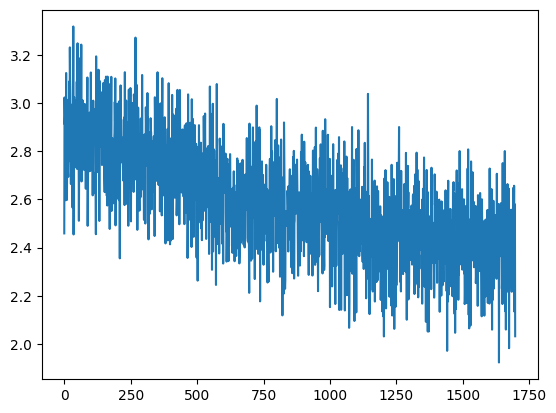

In [ ]:
plt.plot(loss_i)

Test Sentence

In [ ]:
# Get a test sentence
test_sentence = test_dataset[1]['translation']['en']
print(f"Test sentence: {test_sentence}")
# Tokenize and encode the test sentence
input_ids = encode_input_str(test_sentence, 'ja', tokenizer, model.config.max_length, LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()
# print out the tokenized sentence of max length
print("Truncated input:", tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0])))

Test sentence: Randwick has been locked down, and is expected to remain so for up to two months.
Truncated input: <ja> Randwick has been locked down, and is expected to remain so for up</s>


In [ ]:
# convert to new language
output = model.generate(input_ids, num_beams = 10, num_return_sequences = 3)
for token_set in output:
    print(tokenizer.decode(token_set, skip_special_tokens=True))

ランダーウィックが倒壊したと予想されている。
ランダーウィックが倒壊したと予想されているが、現在、その地域は
ランダーウィックが倒壊したと予想されているが、その時点では、この


In [ ]:
def get_all_translation_data(translations, lang_token_map,
                            tokenizer, seq_length=20):
  input_ids = []
  target_ids = []
  
  langs = list(lang_token_map.keys())
  for input_lang, target_lang in itertools.permutations(langs, 2):
    input_text = translations[input_lang]
    target_text = translations[target_lang]
    
    if input_text is None or target_text is None:
        return None, None
    
    input_ids.append(encode_input_str(input_text, target_lang, tokenizer, seq_length, 
                                    lang_token_map))
    
    target_ids.append(encode_target_str(target_text, tokenizer, seq_length))
  
  return input_ids, target_ids

In [ ]:
a, b = get_all_translation_data(train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

In [ ]:
c = []
c = c + a

In [142]:
c

[tensor([250100,  20161,    783,    269,  62956,    345,  15772,    381,  62482,
            281,  23577,    371,    304,    287,   1848,    259,  93887,   4025,
          10291,      1]),
 tensor([250102,  20161,    783,    269,  62956,    345,  15772,    381,  62482,
            281,  23577,    371,    304,    287,   1848,    259,  93887,   4025,
          10291,      1]),
 tensor([250103,  20161,    783,    269,  62956,    345,  15772,    381,  62482,
            281,  23577,    371,    304,    287,   1848,    259,  93887,   4025,
          10291,      1]),
 tensor([250104,  20161,    783,    269,  62956,    345,  15772,    381,  62482,
            281,  23577,    371,    304,    287,   1848,    259,  93887,   4025,
          10291,      1]),
 tensor([250101,  33756,    268,    594,  20161,    262,    740,  15772,    327,
           8218,    263,    294,    381,  62482,    327,    259,  37503,    370,
            371,      1]),
 tensor([250102,  33756,    268,    594,  20161,    262

In [129]:
# choose 2 random languages for i/o
langs = list(LANG_TOKEN_MAPPING.keys())
for input_lang, target_lang in itertools.permutations(langs, 2):
  print(input_lang, target_lang)

en fil
en hi
en id
en ja
fil en
fil hi
fil id
fil ja
hi en
hi fil
hi id
hi ja
id en
id fil
id hi
id ja
ja en
ja fil
ja hi
ja id


In [135]:
# convert the translation data of first data point to input and output tensors
input_ids, output_ids = format_translation_data(train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)
# print out decoded input and output tensors
print(' '.join(tokenizer.convert_ids_to_tokens(input_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(output_ids)))

<ja> ▁Italia ▁ber hasil ▁menga lahkan ▁Portugal ▁3 1-5 ▁di ▁grup ▁C ▁dalam ▁Pia la ▁ Dunia ▁ Rugby </s>
▁ フランス の パリ 、 パル ク ・ デ ・ プラン ス で 行われた 2007 年 ラグビー ワールド カップ </s>
